In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from joblib import dump

### EDA Stroke 

### Context
According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

**Attribute Information**
1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not  
**Note: "Unknown" in smoking_status means that the information is unavailable for this patient**

## Data types

In [2]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
for i in df.columns:
    print('Column '+ i+ ": "+str(df[i].unique()))

Column id: [ 9046 51676 31112 ... 19723 37544 44679]
Column gender: ['Male' 'Female' 'Other']
Column age: [6.70e+01 6.10e+01 8.00e+01 4.90e+01 7.90e+01 8.10e+01 7.40e+01 6.90e+01
 5.90e+01 7.80e+01 5.40e+01 5.00e+01 6.40e+01 7.50e+01 6.00e+01 5.70e+01
 7.10e+01 5.20e+01 8.20e+01 6.50e+01 5.80e+01 4.20e+01 4.80e+01 7.20e+01
 6.30e+01 7.60e+01 3.90e+01 7.70e+01 7.30e+01 5.60e+01 4.50e+01 7.00e+01
 6.60e+01 5.10e+01 4.30e+01 6.80e+01 4.70e+01 5.30e+01 3.80e+01 5.50e+01
 1.32e+00 4.60e+01 3.20e+01 1.40e+01 3.00e+00 8.00e+00 3.70e+01 4.00e+01
 3.50e+01 2.00e+01 4.40e+01 2.50e+01 2.70e+01 2.30e+01 1.70e+01 1.30e+01
 4.00e+00 1.60e+01 2.20e+01 3.00e+01 2.90e+01 1.10e+01 2.10e+01 1.80e+01
 3.30e+01 2.40e+01 3.40e+01 3.60e+01 6.40e-01 4.10e+01 8.80e-01 5.00e+00
 2.60e+01 3.10e+01 7.00e+00 1.20e+01 6.20e+01 2.00e+00 9.00e+00 1.50e+01
 2.80e+01 1.00e+01 1.80e+00 3.20e-01 1.08e+00 1.90e+01 6.00e+00 1.16e+00
 1.00e+00 1.40e+00 1.72e+00 2.40e-01 1.64e+00 1.56e+00 7.20e-01 1.88e+00
 1.24e+00 8.00e-01

In [3]:
display(df)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [4]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

### Standar data

In [5]:
def to_int(val):
    """ Reconoce valores numericos y los transforma a enteros.
    """
    try:
        value = int(val)
    except ValueError:
        value = value
    return value


def standar_data(dataframe):
    columns = ['gender','ever_married','work_type','Residence_type','smoking_status']
    float_columns = ['bmi','avg_glucose_level','age']
    dataframe_columns = dataframe.columns
    for column in dataframe_columns:
        if column in columns:
            dataframe[column] = dataframe[column].str.lower().str.replace(' ', '_').str.replace('-','_')
        elif column not in float_columns :
            dataframe[column] = dataframe[column].map(to_int)
    return dataframe

df = standar_data(df)

In [6]:
for i in df.columns:
    print('Column '+ i+ ": "+str(df[i].unique()))

Column id: [ 9046 51676 31112 ... 19723 37544 44679]
Column gender: ['male' 'female' 'other']
Column age: [6.70e+01 6.10e+01 8.00e+01 4.90e+01 7.90e+01 8.10e+01 7.40e+01 6.90e+01
 5.90e+01 7.80e+01 5.40e+01 5.00e+01 6.40e+01 7.50e+01 6.00e+01 5.70e+01
 7.10e+01 5.20e+01 8.20e+01 6.50e+01 5.80e+01 4.20e+01 4.80e+01 7.20e+01
 6.30e+01 7.60e+01 3.90e+01 7.70e+01 7.30e+01 5.60e+01 4.50e+01 7.00e+01
 6.60e+01 5.10e+01 4.30e+01 6.80e+01 4.70e+01 5.30e+01 3.80e+01 5.50e+01
 1.32e+00 4.60e+01 3.20e+01 1.40e+01 3.00e+00 8.00e+00 3.70e+01 4.00e+01
 3.50e+01 2.00e+01 4.40e+01 2.50e+01 2.70e+01 2.30e+01 1.70e+01 1.30e+01
 4.00e+00 1.60e+01 2.20e+01 3.00e+01 2.90e+01 1.10e+01 2.10e+01 1.80e+01
 3.30e+01 2.40e+01 3.40e+01 3.60e+01 6.40e-01 4.10e+01 8.80e-01 5.00e+00
 2.60e+01 3.10e+01 7.00e+00 1.20e+01 6.20e+01 2.00e+00 9.00e+00 1.50e+01
 2.80e+01 1.00e+01 1.80e+00 3.20e-01 1.08e+00 1.90e+01 6.00e+00 1.16e+00
 1.00e+00 1.40e+00 1.72e+00 2.40e-01 1.64e+00 1.56e+00 7.20e-01 1.88e+00
 1.24e+00 8.00e-01

In [7]:
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

#### Valores nulos

In [8]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

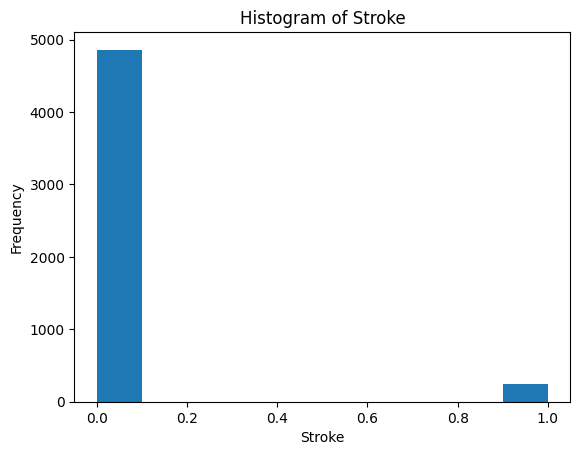

In [9]:
plt.hist(df['stroke'])
plt.xlabel('Stroke')
plt.ylabel('Frequency')
plt.title('Histogram of Stroke')

# Show the plot
plt.show()

In [10]:
df.groupby(['stroke'])['id'].count()

stroke
0    4861
1     249
Name: id, dtype: int64

#### Verificar los datos nulos

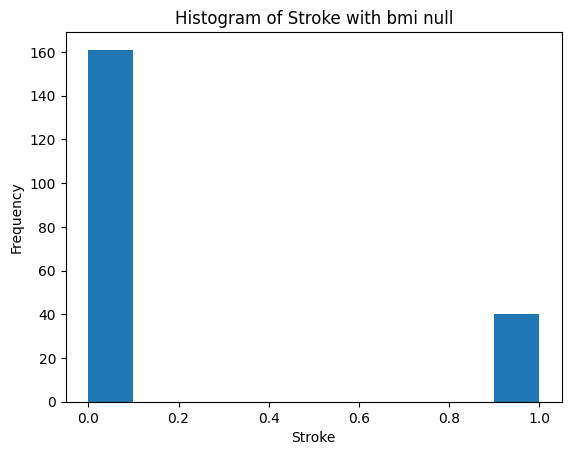

In [11]:
df_null = df[df.bmi.isnull()]
plt.hist(df_null['stroke'])
plt.xlabel('Stroke')
plt.ylabel('Frequency')
plt.title('Histogram of Stroke with bmi null')

# Show the plot
plt.show()

In [12]:
df_null.groupby(['stroke'])['id'].count()

stroke
0    161
1     40
Name: id, dtype: int64

In [13]:
duplicate = df[df.duplicated()]
duplicate

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


### Remplazar los datos de los valores nulos con la media

In [14]:
df["bmi"] = df["bmi"].replace(np.NaN, df["bmi"].mean())
df.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

### Transformación de variables

In [15]:
gender_mapping = {'male': 0, 'female': 1,'other':2, np.nan : 2}
ever_married_mapping = {'no': 0, 'yes': 1, np.nan : 2}
work_type_mapping = {'never_worked': 0, 'govt_job': 1, 'self_employed': 2, 'children' : 3, 'private' : 4, np.nan : 5}
Residence_type_mapping = {'rural': 0, 'urban': 1, np.nan : 2}
smoking_status_mapping = {'smokes': 0, 'formerly_smoked': 1, 'unknown': 2, 'never_smoked' : 3, np.nan : 4}

df['gender'] = df['gender'].map(gender_mapping)
df['ever_married'] = df['ever_married'].map(ever_married_mapping)
df['work_type'] = df['work_type'].map(work_type_mapping)
df['Residence_type'] = df['Residence_type'].map(Residence_type_mapping)
df['smoking_status'] = df['smoking_status'].map(smoking_status_mapping)

In [16]:
for i in df.columns:
    print('Column '+ i+ ": "+str(df[i].unique()))

Column id: [ 9046 51676 31112 ... 19723 37544 44679]
Column gender: [0 1 2]
Column age: [6.70e+01 6.10e+01 8.00e+01 4.90e+01 7.90e+01 8.10e+01 7.40e+01 6.90e+01
 5.90e+01 7.80e+01 5.40e+01 5.00e+01 6.40e+01 7.50e+01 6.00e+01 5.70e+01
 7.10e+01 5.20e+01 8.20e+01 6.50e+01 5.80e+01 4.20e+01 4.80e+01 7.20e+01
 6.30e+01 7.60e+01 3.90e+01 7.70e+01 7.30e+01 5.60e+01 4.50e+01 7.00e+01
 6.60e+01 5.10e+01 4.30e+01 6.80e+01 4.70e+01 5.30e+01 3.80e+01 5.50e+01
 1.32e+00 4.60e+01 3.20e+01 1.40e+01 3.00e+00 8.00e+00 3.70e+01 4.00e+01
 3.50e+01 2.00e+01 4.40e+01 2.50e+01 2.70e+01 2.30e+01 1.70e+01 1.30e+01
 4.00e+00 1.60e+01 2.20e+01 3.00e+01 2.90e+01 1.10e+01 2.10e+01 1.80e+01
 3.30e+01 2.40e+01 3.40e+01 3.60e+01 6.40e-01 4.10e+01 8.80e-01 5.00e+00
 2.60e+01 3.10e+01 7.00e+00 1.20e+01 6.20e+01 2.00e+00 9.00e+00 1.50e+01
 2.80e+01 1.00e+01 1.80e+00 3.20e-01 1.08e+00 1.90e+01 6.00e+00 1.16e+00
 1.00e+00 1.40e+00 1.72e+00 2.40e-01 1.64e+00 1.56e+00 7.20e-01 1.88e+00
 1.24e+00 8.00e-01 4.00e-01 8.00e-02

In [17]:
df.drop(['id'], axis = 1, inplace = True) 

### Matriz de correlacion

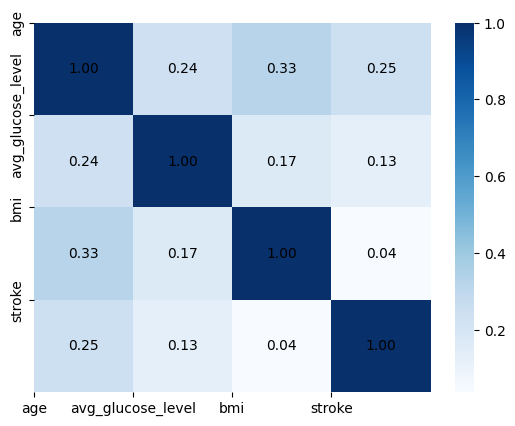

In [18]:
df_numerical = ['age', 'avg_glucose_level', 'bmi', 'stroke']
numeric_columns = df[df_numerical]
corr_matrix = numeric_columns.corr()
sns.heatmap(corr_matrix, cmap='Blues')
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        text = '{:.2f}'.format(corr_matrix.iloc[i, j])
        plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black', fontsize=10)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.show()

#### Numerical attributes

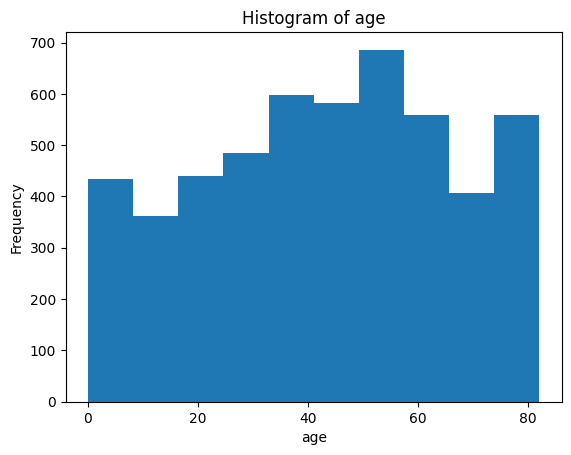

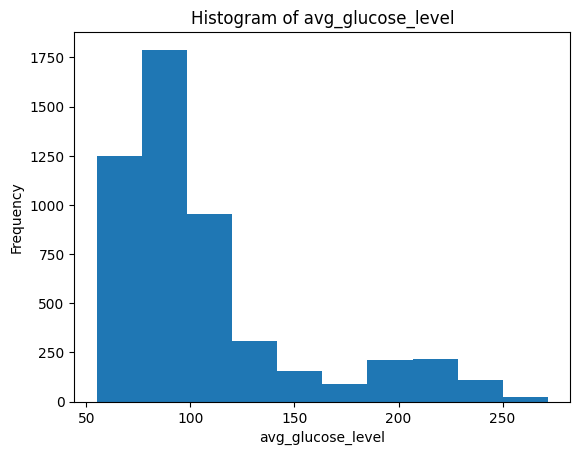

In [19]:
df_numerical2 = ['age','avg_glucose_level']
for column in df_numerical2:
    plt.hist(df[column])
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

#### Categorical attributes

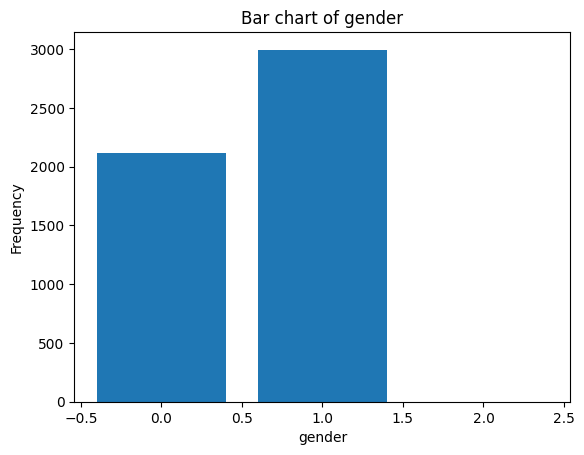

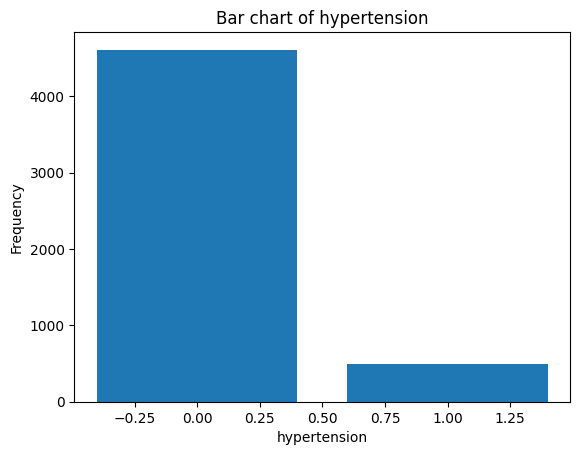

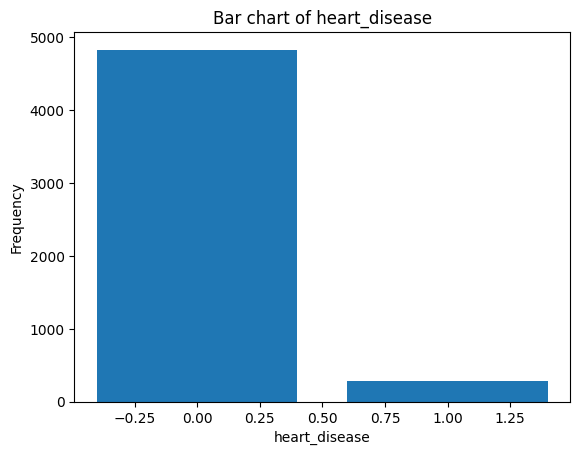

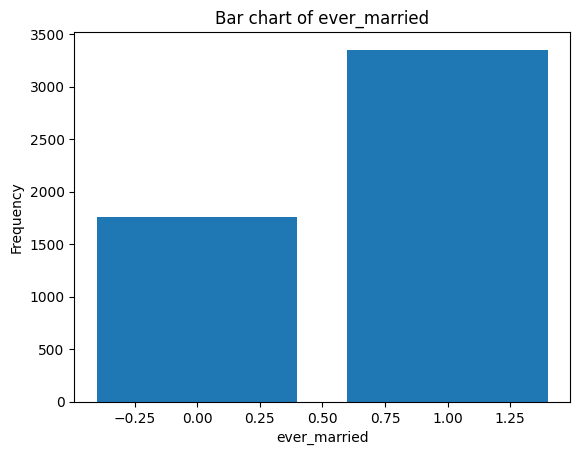

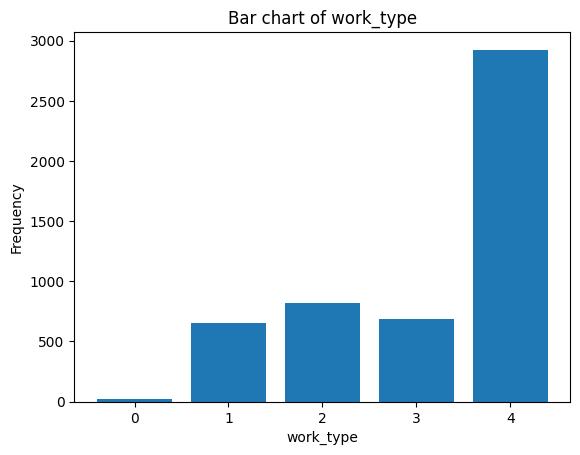

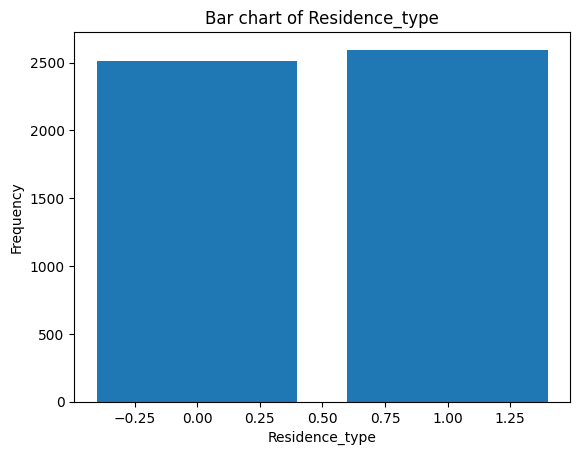

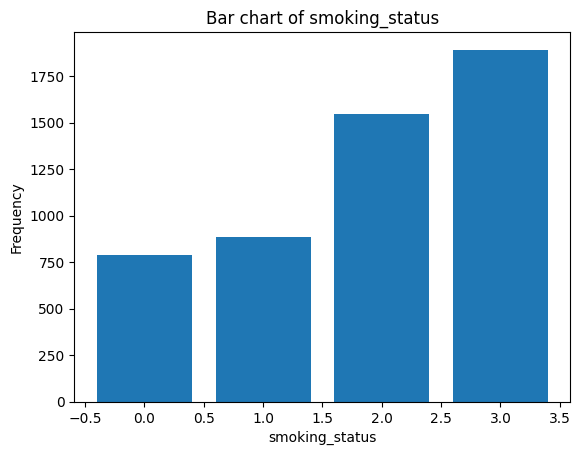

In [20]:
df_categorical = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for column in df_categorical:
    values, counts = np.unique(df[column], return_counts=True)
    plt.bar(values, counts)
    plt.title(f'Bar chart of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency') 
    plt.show() 

In [21]:
variable_names = []
chi2_p_values = []
for var in df_categorical:
    contingency_table = pd.crosstab(df[var], df['stroke'])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    variable_names.append(var)
    chi2_p_values.append(p)
chi2_results = pd.DataFrame({'Categorical Variable': variable_names, 'Chi-Square p-value': chi2_p_values})
chi2_results = chi2_results.sort_values(by='Chi-Square p-value')
print(chi2_results)
df.shape

  Categorical Variable  Chi-Square p-value
2        heart_disease        2.088785e-21
1         hypertension        1.661622e-19
3         ever_married        1.638902e-14
4            work_type        5.397708e-10
6       smoking_status        2.085400e-06
5       Residence_type        2.983317e-01
0               gender        7.895491e-01


(5110, 11)

In [22]:
df.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

### Data preprocesing

In [23]:
features = ["age",'hypertension', 'heart_disease', 'ever_married', 'work_type']
# Split data to training and testing
X = df[features]
y = df['stroke']

# Specify train_size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
## Save the standar scaler
dump(scaler, 'scaler_model.joblib')

['scaler_model.joblib']

### Oversampling using SMOTE

In [25]:
# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [26]:
print("Before SMOTE:" + str(len(X_train)))
print("After SMOTE:" + str(len(X_train_smote)))

Before SMOTE:4088
After SMOTE:7802


### RandomForestClassifier

#### Find best parameters

In [27]:
rfc = RandomForestClassifier(random_state=42)
forest_params = [{'max_depth': list(range(10, 15)), 'max_features': list(range(0,14))}]
clf = GridSearchCV(rfc, forest_params, cv = 10, scoring='accuracy',n_jobs=-1)
clf.fit(X_train_smote, y_train_smote)

C:\Users\jonat\anaconda3\envs\DataPath\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
50 fits failed out of a total of 700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jonat\anaconda3\envs\DataPath\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jonat\anaconda3\envs\DataPath\Lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\jonat\anaconda3\envs\DataPath\Lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constra

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             n_jobs=-1,
             param_grid=[{'max_depth': [10, 11, 12, 13, 14],
                          'max_features': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                           12, 13]}],
             scoring='accuracy')

In [28]:
print(clf.best_params_)
print(clf.best_score_)

{'max_depth': 14, 'max_features': 5}
0.9272105124922024


#### Training model

In [29]:
rf_classifier = RandomForestClassifier(max_depth=14, max_features=5,random_state=42)
rf_classifier.fit(X_train_smote, y_train_smote)
y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion)
print("Classification Report:\n", classification_rep)

Accuracy: 0.8972602739726028
Confusion Matrix:
 [[897  63]
 [ 42  20]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.93      0.94       960
           1       0.24      0.32      0.28        62

    accuracy                           0.90      1022
   macro avg       0.60      0.63      0.61      1022
weighted avg       0.91      0.90      0.90      1022



In [30]:
dump(rf_classifier, 'rf_classifier_model.joblib')

['rf_classifier_model.joblib']